# Project: Wrangling and Analyze Data

In [1]:
import requests as r
import pandas as pd
import numpy as np
import tweepy
import urllib, json
import os
from PIL import Image
from io import BytesIO
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import matplotlib.pyplot as plt
import seaborn as sb

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_1= pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
folder= 'image_prediction'
if not os.path.exists (folder):
    os.makedirs(folder)
    
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response= r.get(url)
with open ('image-predictions.tsv', 'wb') as file:
    file.write(response.content)
    
df_2= pd.read_csv('image-predictions.tsv', '\t')


C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
consumer_key = 'ReaVgydaEm5exW46DiALxP3r1'
consumer_secret = 'Ytk0pqEbhnIXA6R5aod4KpPO4ISXJp8x1hHnLtqQq4Gcus0vcc'
access_token = '150248066-rARUQEAEGugJ6vItNEghr2oBuMgRNJ5ByrW1thrJ'
access_secret = 'buzWzhKx11nta87VDr3XZAjUx9t5Js7Il3WMR8kZ0hLFE'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

'''# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            print (tweet_id, 'success')
        except tweepy.TweepyException  as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''
extract_list = []
for line in open('tweet_json.txt', 'r'):
    data= json.loads(line)
    extract_list.append({'twitter_id': data['id_str'],
                         'favorite_count': data['favorite_count'],
                         'retweet_count': data ['retweet_count']})
    
df_3= pd.DataFrame(extract_list, columns = ['twitter_id','retweet_count', 'favorite_count'])


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality issues

1.	Timestamp in archived_data is in one column, which needs three separate columns for months, days, and year
2.	We only need the original tweet. Hence, we can remove all the columns that include data associated with retweets
3.	Remove the unnecessary parts from at the end of each row of the 'text' columns
4.	It is not necessary to have separate columns of doggo,floofer, pupper,puppo as they include the same information
5.	In the 'name' column of the archived_data table, some invalid names that I have assumed can not be any dog's name. Hence, I have removed those names and 'None' entries with an empty string.
6.	The denominator should not be more than 10, and Numerator should be <= 10. But there are instances where these conditions were not followed. Because of this, the result it will produce will be invalid

8.	It is pertinent to get rid of the HTML from the 'source' column in the archived_data table and replace them with 'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck.'
9.	In the image_data table, we don't need the 'img_num' column. Hence, we can remove that column from the table
10.	Remove duplicated rows from the jpg_url column in the 'image_data' table


### Tidiness issues
1. twitter_id column in the json_data dataset is in object format, convert it to int

2. merging all the tables together to make our effort of storing the dataframe easy

3. In the image_data dataframe, column: p1,p2 and p3 include the name of the dogs in lower and uppercase letter. 

4. renaming the twitter_id to tweet_id in the jason_data table to make make the merging swift

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

#### Make copies of original pieces of data

In [5]:
archived_data= df_1.copy()
image_data= df_2.copy()
json_data= df_3.copy()

In [6]:
archived_data.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
777,776088319444877312,NaN,NaN,2016-09-14 16:00:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't tap the screen to make the hearts appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776088319...,10,10,None,None,None,None,None
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Yep... just as I suspected. Yo...",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,https://twitter.com/dog_rates/status/777684233...,12,10,None,None,None,None,None
492,813217897535406080,NaN,NaN,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is Atlas. He went all out this year. 13/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813217897...,13,10,Atlas,None,None,None,None
2031,671768281401958400,NaN,NaN,2015-12-01 19:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you try to recreate the scene from Lady &...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671768281...,10,10,None,None,None,None,None
2078,670832455012716544,NaN,NaN,2015-11-29 05:11:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Amy. She is Queen Starburst. 10/10 une...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670832455...,10,10,Amy,None,None,None,None


In [7]:
image_data.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
2006,877611172832227328,https://pbs.twimg.com/media/DCszHgmW0AAmIpT.jpg,1,Irish_setter,0.364729,True,golden_retriever,0.202907,True,Irish_terrier,0.107473,True
1666,812709060537683968,https://pbs.twimg.com/media/C0dSk98WEAALyya.jpg,1,Irish_setter,0.326873,True,golden_retriever,0.182610,True,Leonberg,0.156912,True
1676,813172488309972993,https://pbs.twimg.com/media/C0j4EESUsAABtMq.jpg,1,doormat,0.954844,False,golden_retriever,0.026193,True,cocker_spaniel,0.004386,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [8]:
json_data.sample(5)

,twitter_id,retweet_count,favorite_count
2306,666817836334096384,267,540
595,798697898615730177,7602,0
582,800188575492947969,4581,0
1943,673707060090052608,434,1177
804,772114945936949249,546,3005


### Issue #1:
Time stamp in archived_data is in one column which needs 3 seperate columns for months, days and year

#### Define:
Creating four seperate columns for 'year', 'time','month','day' from the 'timestamp' column. Then drop the 'timestamp' column.

#### Code

In [9]:
archived_data['year']= pd.to_datetime(archived_data['timestamp']).dt.year
archived_data['time'] = pd.to_datetime(archived_data['timestamp']).dt.time
archived_data['month'] = pd.to_datetime(archived_data['timestamp']).dt.month
archived_data['day'] = pd.to_datetime(archived_data['timestamp']).dt.day
archived_data.drop("timestamp", axis=1,inplace=True)

#### Test

In [10]:
archived_data.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,time,month,day
681,788765914992902144,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Butter. She can have whatever she want...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788765914...,12,10,Butter,None,None,None,None,2016,15:37:03,10,19
418,822462944365645825,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Gabe. He was the unequivocal embodimen...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822462944...,14,10,Gabe,None,None,pupper,None,2017,15:17:01,1,20


### Issue #2:
We only need original tweet.Hence,we can remove all the columns that includes data associated with retweets

#### Define
Using the drop method on the 'achived_data' dataframe to delete all the following columns (in_reply_to_user_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp,expanded_urls)

#### Code

In [11]:
archived_data.drop(['in_reply_to_user_id','in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp','expanded_urls'], axis=1,inplace=True)

#### Test

In [12]:
archived_data.head()

,tweet_id,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,time,month,day
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,2017,16:23:56,8,1
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,2017,00:17:27,8,1
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,2017,00:18:03,7,31
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,2017,15:58:51,7,30
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,2017,16:00:24,7,29


### Issue #3:
Remove the unnecessary parts from at the end of each rows of the 'text' coulmns
#### Define
1. The entire text column was not visible in the workspace, so it was necessary to make it visible using the set_options method
2. Then using the str.split method each row was divided into 7 columns
3. Then rename the column as the title of each column was integer
4. selecting only the first column and remove the last part of each rows which had '10/13' like string part
5. Replace the output column with the 'text' column in the achived_data dataframe. 
#### Code

In [13]:
pd.set_option('display.max_colwidth',-1)
archived_test= archived_data.text.str.split('/',expand=True)
archived_test= archived_test.rename(columns={0: 'zero',1: 'One', 2: 'Two', 3: 'Three', 4: 'Four', 5: 'Five', 6: 'Six', 7: 'Seven'})
archived_test.drop(['One','Two','Three','Four','Five','Six','Seven'], axis=1, inplace= True)
archived_test['zero']= archived_test.zero.str[:-2]
archived_data['text']= archived_test['zero']



C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/2854549518.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


#### Test

In [14]:
archived_data.pupper.value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

### Issue #4:
It is not necessary to have separate columns of doggo,floofer, pupper,puppo as they include the same information



#### Define
Create a different table (archive_dog) to have a clear view of all the columns together. Then Replace all the None values from each column and creathe a new column 'breed' by adding all the columns ('doggo','pupper','floofer','puppo'). Then drop all the dogs' name column and keep the newly created breed column. At last, add the breed column in the archived_data table



#### Code

In [15]:
archive_dog= archived_data [['name','doggo','floofer','pupper','puppo']]
archive_dog['doggo']= archive_dog.doggo.replace('None','')
archive_dog['floofer']= archive_dog.floofer.replace('None','')
archive_dog['pupper']= archive_dog.pupper.replace('None','')
archive_dog['puppo']= archive_dog.puppo.replace('None','')
archive_dog['breed']= (archive_dog['doggo'])+' ' +(archive_dog['floofer'])+' ' +(archive_dog['puppo'])+' ' +(archive_dog['pupper'])
archived_data ['breed']= archive_dog['breed']
archived_data.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)


C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3795826363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_dog['doggo']= archive_dog.doggo.replace('None','')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3795826363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_dog['floofer']= archive_dog.floofer.replace('None','')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3795826363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

#### Test

In [16]:
archived_data.sample(3)

,tweet_id,source,text,rating_numerator,rating_denominator,name,year,time,month,day,breed
572,801285448605831168,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",oh h*ck,10,10,None,2016,04:45:12,11,23,
380,827600520311402496,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Tucker. It's his birthday. He's pupset with you because you're too busy playing @GoodDogsGame to celebrate.,13,10,Tucker,2017,19:31:54,2,3,
294,837482249356513284,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Waffles. He's a ship captain in real life and in @GoodDogsGame. Must've gotten to the max level (wink),13,10,Waffles,2017,01:58:22,3,3,


### Issue #5:
In the 'name' column of archived_data table there are some invalid names which I have assumed can not be the name of any dog. Hence, I have decided to remove those names and 'None' entries with an empty string. 
#### Define
To do that, all those invalid vaues were listed into 'invalid_names' list and using a for loop those name were replaced.

#### Code

In [17]:
invalid_names= ['a','An','the','all','None','very','one','space','such','quite','unacceptable','this','officially','old','not','my','mad','light','life','just','infuriating','get','incredibly','his','getting','by','an','actually','O',]
for name in invalid_names:
    archived_data.name.replace(name,'',inplace= True)
print(archived_data['name'])






0       Phineas 
1       Tilly   
2       Archie  
3       Darla   
4       Franklin
          ...   
2351            
2352            
2353            
2354            
2355            
Name: name, Length: 2356, dtype: object


#### Test

In [18]:
archived_data.name.sample(5)


2265    Frank  
1598           
627     Rizzy  
440            
1404    Calbert
Name: name, dtype: object

### Issue #6 and #7:
Denominator should not be more than 10 and Numerator should be <= 10. But there are instances where these conditins were not followed. Becauyse of this the result it will produce will be invalid

Lets see in how many cases did not abide by this condition.
#### Define
using the min and max on these two columns and then summing up the number where the above condition was not followed.

#### Code

In [19]:
sum(archived_data.rating_denominator!= 10)

23

In [20]:
sum(archived_data.rating_numerator > 10)

1455

#### Test

In [21]:
sum(archived_data.rating_denominator!= 10)
sum(archived_data.rating_numerator > 10)

1455

### Issue #8:
It is pertinent to get rid off the HTML from the 'source' column in the archived_data table and replace them with 
'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck'
#### Define
Use the replace method on the 4 HTML to replace them with 'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck'.

#### Code

In [22]:
archived_data.source= archived_data.source.str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','Twitter for iPhone')
archived_data.source= archived_data.source.str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine - Make a Scene')
archived_data.source= archived_data.source.str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client')
archived_data.source= archived_data.source.str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','TweetDeck')

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3409894765.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  archived_data.source= archived_data.source.str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','Twitter for iPhone')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3409894765.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  archived_data.source= archived_data.source.str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine - Make a Scene')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3409894765.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  archived_data.source= archived_data.source.str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13564/3409894765.py

#### Test

In [23]:
archived_data.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

### Issue #9:
In the image_data table, we dont need the 'img_num' column. Hence, we cam remove that column for the table
#### Define
Using the drop method to drop the img_num column from the table

#### Code

In [24]:
image_data= image_data.drop(['img_num'], axis=1)

#### Test

In [25]:
image_data.sample(2)

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1819,834209720923721728,https://pbs.twimg.com/media/C5O1UAaWIAAMBMd.jpg,golden_retriever,0.754799,True,Pekinese,0.197861,True,Labrador_retriever,0.008654,True
1366,761672994376806400,https://pbs.twimg.com/ext_tw_video_thumb/761672828462718981/pu/img/R00UYAAWB3GtuHdI.jpg,gondola,0.318851,False,sea_lion,0.306525,False,pool_table,0.111565,False


### Issue #10:
Remove duplicated rows from the jpg_url column in the 'image_data' table
#### Define
use drop_duplicates() method to drop the duplicated rows from the 'jpg_url' column

#### Code

In [26]:
image_data= image_data.drop_duplicates(subset ="jpg_url",
                     keep = False)

#### Test

In [27]:
image_data.jpg_url.duplicated().sum()

0

### Tidiness issues
1.	'twitter_id' column in the 'json_data' table is in object format. Convert it to 'int'
2.	Change the column name from twitter_id to tweet_id
3.	Only keep the rows where p1_dog, p2_dog and p3_dog is true in the image_data table
4.	Change the column name of the respective columns from the image_data table: (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3	p3_conf, p3_dog). Making these column names descriptive would be easier for the reader to grasp what these column titles intend to mean.
5.	In the image_data data frame, column: p1,p2 and p3 include the name of the dogs in lower and uppercase letters.
6.	Merging tables based on tweet_id as this column exists in all the tables


### Issue #1:
'twitter_id' column in the 'json_data' table is in object format, convert it to 'int'
#### Define
Use the 'astype('int64')' method on 'twitter_id' column of 'json_data' table

#### Code

In [28]:
json_data['twitter_id'] = json_data['twitter_id'].astype('int64')

#### Test

In [29]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   twitter_id      2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


### Issue #2:
Change the column name from twitter_id to tweet_id
#### Define
Using the dataframe.rename function

#### Code

In [30]:
json_data.rename(columns={'twitter_id': 'tweet_id'},inplace= True)

#### Test

In [31]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


### Issue #3:
Only keep the rows where p1_dog, p2_dog and p3_dog is true in the image_data table
#### Define
Selecting all the rows (p1_dog, p2_dog and p3_dog) where their values were true

#### Code

In [32]:
image_data= image_data [((image_data['p1_dog']== True) & (image_data['p2_dog']== True) & (image_data['p3_dog']== True))]

#### Test

In [33]:
image_data [((image_data['p1_dog']== False) & (image_data['p2_dog']== False) & (image_data['p3_dog']== False))]

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Issue #4:
Change the column name of the respective columns from the image_data table: (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3	p3_conf, p3_dog). By making these column names descriptive it would be easier for the reader to grasp what these column title intend to mean. 
#### Define
Using the df_rename function on these columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) and change them as follows:
p1 to prediction_1,
p2 to prediction_2,
p3 to prediction_3,
p1_conf to confidence_1,
p2_conf to confidence_2,
p3_conf to confidence_3,
p1_dog to confidence_result_1,
p2_dog to confidence_result_2,
p3_dog to confidence_result_3

#### Code

In [34]:
image_data.rename(columns={'p1': 'prediction_1','p2': 'prediction_2', 'p3': 'prediction_3',
                          'p1_conf': 'confidence_1','p2_conf': 'confidence_2','p3_conf': 'confidence_3',
                          'p1_dog': 'confidence_result_1', 'p2_dog': 'confidence_result_2','p3_dog': 'confidence_result_3'},inplace= True)

In [35]:
image_data

,tweet_id,jpg_url,prediction_1,confidence_1,confidence_result_1,prediction_2,confidence_2,confidence_result_2,prediction_3,confidence_3,confidence_result_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


### Issue #5:
In the image_data dataframe, column: p1,p2 and p3 include the name of the dogs in lower and uppercase letter.
#### Define
Capitalize the very first letter of all dogs' name in those columns using the str.title() method. 

#### Code

In [36]:
image_data ['prediction_1'] = image_data ['prediction_1'].str.title()
image_data ['prediction_2'] = image_data ['prediction_2'].str.title()
image_data ['prediction_3'] = image_data ['prediction_3'].str.title()

#### Test

In [37]:
image_data ['prediction_1']
image_data ['prediction_2']
image_data ['prediction_3']


0       Shetland_Sheepdog          
1       Rhodesian_Ridgeback        
2       Bloodhound                 
3       Miniature_Pinscher         
4       Doberman                   
          ...                      
2066    Chesapeake_Bay_Retriever   
2067    Pembroke                   
2070    German_Short-Haired_Pointer
2072    Kelpie                     
2073    Papillon                   
Name: prediction_3, Length: 1169, dtype: object

### Issue #6:
Merging tables together based on tweet_id as this column exist in all the tables
#### Define
using the pd.merge () to merge the tables together

#### Code

In [38]:
we_rate_dogs= archived_data.merge(image_data, on='tweet_id')


In [39]:
we_rate_dogs_data=we_rate_dogs.merge(json_data, on='tweet_id')

#### Test

In [40]:
we_rate_dogs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             1169 non-null   int64  
 1   source               1169 non-null   object 
 2   text                 1169 non-null   object 
 3   rating_numerator     1169 non-null   int64  
 4   rating_denominator   1169 non-null   int64  
 5   name                 1169 non-null   object 
 6   year                 1169 non-null   int64  
 7   time                 1169 non-null   object 
 8   month                1169 non-null   int64  
 9   day                  1169 non-null   int64  
 10  breed                1169 non-null   object 
 11  jpg_url              1169 non-null   object 
 12  prediction_1         1169 non-null   object 
 13  confidence_1         1169 non-null   float64
 14  confidence_result_1  1169 non-null   bool   
 15  prediction_2         1169 non-null   o

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [41]:
we_rate_dogs_data.to_csv("twitter_archive_master.csv")

#### Test

In [42]:
pd.read_csv("twitter_archive_master.csv")

,Unnamed: 0,tweet_id,source,text,rating_numerator,rating_denominator,name,year,time,month,...,confidence_1,confidence_result_1,prediction_2,confidence_2,confidence_result_2,prediction_3,confidence_3,confidence_result_3,retweet_count,favorite_count
0,0,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",13,10,Tilly,2017,00:17:27,8,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,6514,33819
1,1,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.,12,10,Archie,2017,00:18:03,7,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,4328,25461
2,2,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such.",12,10,Franklin,2017,16:00:24,7,...,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True,9774,41048
3,3,890729181411237888,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy.,13,10,NaN,2017,00:22:40,7,...,0.566142,True,Eskimo_Dog,0.178406,True,Pembroke,0.076507,True,16716,56848
4,4,890609185150312448,Twitter for iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet.,13,10,Zoey,2017,16:25:51,7,...,0.487574,True,Irish_Setter,0.193054,True,Chesapeake_Bay_Retriever,0.118184,True,4429,28226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,1164,666049248165822465,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased.,5,10,NaN,2015,00:24:50,11,...,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,41,111
1165,1165,666044226329800704,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron.,6,10,NaN,2015,00:04:52,11,...,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True,147,311
1166,1166,666033412701032449,Twitter for iPhone,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue.,9,10,NaN,2015,23:21:54,11,...,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,47,128
1167,1167,666029285002620928,Twitter for iPhone,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here.,7,10,NaN,2015,23:05:30,11,...,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True,48,132


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Visualization

#### The most common tweet source'e name

In [43]:
common_source= we_rate_dogs_data['source'].value_counts()
common_source

Twitter for iPhone    1151
Twitter Web Client    13  
TweetDeck             5   
Name: source, dtype: int64

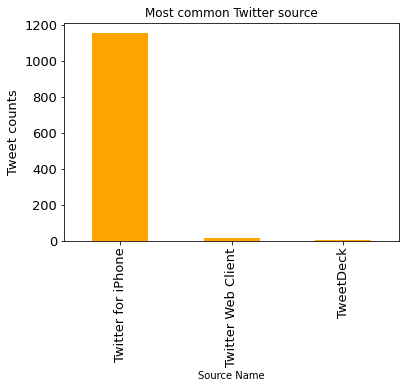

In [44]:
common_source. plot.bar(color = 'orange', fontsize = 13)
plt.title('Most common Twitter source', color = 'black')
plt.xlabel('Source Name', color = 'black')
plt.ylabel('Tweet counts', color = 'black', fontsize = '13');
plt.show()

#### Common Dog's name

In [45]:
Common_dog_name= we_rate_dogs_data.name.value_counts()[1:]
Common_dog_name

Cooper     9
Charlie    8
Oliver     7
Sadie      6
Koda       6
          ..
Stormy     1
Frankie    1
Dallas     1
Mattie     1
Walter     1
Name: name, Length: 617, dtype: int64

#### Most popular dog's stages

In [46]:
Common_dog_stage= we_rate_dogs_data.breed.value_counts()[1:]
Common_dog_stage

   pupper          117
doggo              37 
  puppo            18 
 floofer           6  
doggo   pupper     5  
doggo  puppo       1  
doggo floofer      1  
Name: breed, dtype: int64

### Insights:
1.The most common source of tweet is posted from the iphone users

2.The three most popular/common dog's names are: Cooper, Charlie and Oliver

3.The most common stage is pupper,doggo,puppo respectively

,tweet_id,source,text,rating_numerator,rating_denominator,name,year,time,month,day,...,confidence_1,confidence_result_1,prediction_2,confidence_2,confidence_result_2,prediction_3,confidence_3,confidence_result_3,retweet_count,favorite_count
0,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",13,10,Tilly,2017,00:17:27,8,1,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,6514,33819
1,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.,12,10,Archie,2017,00:18:03,7,31,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,4328,25461
2,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such.",12,10,Franklin,2017,16:00:24,7,29,...,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True,9774,41048
3,890729181411237888,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy.,13,10,,2017,00:22:40,7,28,...,0.566142,True,Eskimo_Dog,0.178406,True,Pembroke,0.076507,True,16716,56848
4,890609185150312448,Twitter for iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet.,13,10,Zoey,2017,16:25:51,7,27,...,0.487574,True,Irish_Setter,0.193054,True,Chesapeake_Bay_Retriever,0.118184,True,4429,28226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,666049248165822465,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased.,5,10,,2015,00:24:50,11,16,...,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,41,111
1165,666044226329800704,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron.,6,10,,2015,00:04:52,11,16,...,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True,147,311
1166,666033412701032449,Twitter for iPhone,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue.,9,10,,2015,23:21:54,11,15,...,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,47,128
1167,666029285002620928,Twitter for iPhone,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here.,7,10,,2015,23:05:30,11,15,...,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True,48,132


In [79]:
(we_rate_dogs_data.prediction_1.value_counts())

Golden_Retriever       112
Pembroke               76 
Labrador_Retriever     73 
Chihuahua              46 
Pug                    39 
                       .. 
Scotch_Terrier         1  
Groenendael            1  
Clumber                1  
Irish_Water_Spaniel    1  
Silky_Terrier          1  
Name: prediction_1, Length: 110, dtype: int64

In [80]:
(we_rate_dogs_data.prediction_2.value_counts())

Labrador_Retriever    66
Cardigan              62
Golden_Retriever      52
French_Bulldog        31
Chihuahua             31
                      ..
Dalmatian             1 
Briard                1 
Affenpinscher         1 
Mexican_Hairless      1 
Komondor              1 
Name: prediction_2, Length: 112, dtype: int64

In [81]:
(we_rate_dogs_data.prediction_3.value_counts())


Labrador_Retriever      60
Chihuahua               47
Golden_Retriever        32
Eskimo_Dog              30
Pekinese                27
                        ..
Kerry_Blue_Terrier      1 
Standard_Schnauzer      1 
Sussex_Spaniel          1 
Komondor                1 
Bouvier_Des_Flandres    1 
Name: prediction_3, Length: 116, dtype: int64

#### The most common predicted dog in the first prediction

[Text(0.5, 1.0, "most common predicted dog's breed")]

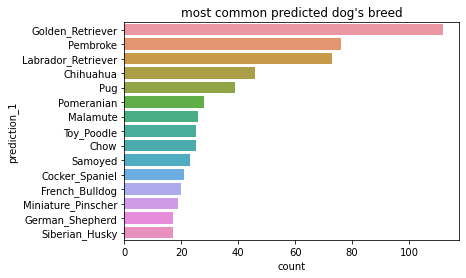

In [89]:
sb.countplot(data=we_rate_dogs_data, y='prediction_1', order=we_rate_dogs_data.prediction_1.value_counts().index[0:15]).set(title="most common predicted dog's breed")

In [118]:
we_rate_dogs_data['year']= we_rate_dogs_data['year'].astype(str)
we_rate_dogs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             1169 non-null   int64  
 1   source               1169 non-null   object 
 2   text                 1169 non-null   object 
 3   rating_numerator     1169 non-null   int64  
 4   rating_denominator   1169 non-null   int64  
 5   name                 1169 non-null   object 
 6   year                 1169 non-null   object 
 7   time                 1169 non-null   object 
 8   month                1169 non-null   int64  
 9   day                  1169 non-null   int64  
 10  breed                1169 non-null   object 
 11  jpg_url              1169 non-null   object 
 12  prediction_1         1169 non-null   object 
 13  confidence_1         1169 non-null   float64
 14  confidence_result_1  1169 non-null   bool   
 15  prediction_2         1169 non-null   o